# Определение стоимости автомобилей

## Подготовка данных

### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

* качество предсказания;
* скорость предсказания;
* время обучения.

### Описание данных

Данные находятся в файле /datasets/autos.csv.

**Признаки:**

* ``DateCrawled`` — дата скачивания анкеты из базы
* ``VehicleType`` — тип автомобильного кузова
* ``RegistrationYear`` — год регистрации автомобиля
* ``Gearbox`` — тип коробки передач
* ``Power`` — мощность (л. с.)
* ``Model`` — модель автомобиля
* ``Kilometer`` — пробег (км)
* ``RegistrationMonth`` — месяц регистрации автомобиля
* ``FuelType`` — тип топлива
* ``Brand`` — марка автомобиля
* ``NotRepaired`` — была машина в ремонте или нет
* ``ateCreated`` — дата создания анкеты
* ``NumberOfPictures`` — количество фотографий автомобиля
* ``PostalCode`` — почтовый индекс владельца анкеты (пользователя)
* ``LastSeen`` — дата последней активности пользователя

**Целевой признак:**

* ``Price`` — цена (евро)

### Открываем и изучаем файл

Импортируем необходимые в работе библиотеки и модули

In [206]:
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error as mse

import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn import preprocessing

import warnings

warnings.filterwarnings('ignore')

In [207]:
# откроем датасет и сохраним его в новой переменной
df = pd.read_csv('/datasets/autos.csv')

In [208]:
# выведем первые пять строк таблицы
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [209]:
# посмотрим на форму датасета
df.shape

(354369, 16)

In [210]:
# Выведем информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [211]:
# Посмотрим на список характерных значений
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Как видим, в данных есть пропуски, нужно будет их обработать.

### Предобработка данных

#### Обработка дубликатов

Проверим данные на наличие явных дубликатов

In [212]:
print('Количество дубликатов в данных:', sum(df.duplicated()))

Количество дубликатов в данных: 4


Удалим дубликаты

In [213]:
df = df.drop_duplicates()

In [214]:
print('Количество дубликатов после удаления:', sum(df.duplicated()))

Количество дубликатов после удаления: 0


#### Поиск и обработка аномалий в признаках

##### Признак ``Price``

Из предварительного списка характерных значений выше видим, что присутствуют нулевые значения цены. Посмотрим сколько таких объявлений.

In [215]:
print(f"Количество объявлений с нулевой ценой: {len(df.loc[df['Price'] == 0])}")

Количество объявлений с нулевой ценой: 10772


Данные о нулевой цене либо внесены ошибочно, либо пользователи не указывали цену в объявлении. На данный момент нет возможности восстановить целевой признак в этих объектах. Удалим их, чтобы не портить модель.

In [216]:
df = df.loc[df['Price'] != 0]

Теперь посмотрим на гистограмму ``'Price'``

<AxesSubplot:xlabel='Price', ylabel='Count'>

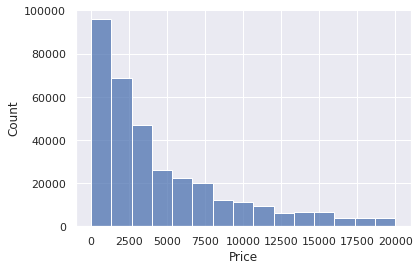

In [217]:
# строим гистограмму для наглядности
sns.histplot(df['Price'], bins=15)

##### Признак ``Model``

Посмотрим на количество объявлений с незаполненной моделью автомобиля:

In [218]:
print(f"Количество объявлений с незаполненной моделью: {len(df.loc[df['Model'].isna()])}")

Количество объявлений с незаполненной моделью: 17521


Признак ``Model`` является одним из основных для предсказания цены. Пропущено порядка 5% данных в этом признаке. Нет возможности восстановить корректно эти данные, удалим пропуски.

In [219]:
df = df.loc[~df['Model'].isna()]

In [220]:
print(f"Количество объявлений с незаполненной моделью после удаления: {len(df.loc[df['Model'].isna()])}")

Количество объявлений с незаполненной моделью после удаления: 0


##### Признак ``Power``

Посмотрим на количество авто с мощностью двигателя более 600 л.с.:

In [221]:
print(f"Количество автомобилей с мощностью > 400 л.с.: {len(df.loc[(df['Power'] > 400) | (df['Power'] <= 0)])}")

Количество автомобилей с мощностью > 400 л.с.: 31966


Будем считать, что мощность выше 400 л.с. в данном случае нам неподходит (не включаем сюда самосвалы гиганты под 4000 л.с.:). Поэтому заменим эти значения медианными среди автомобилей той же модели.

In [222]:
df.loc[(df['Power'] > 400) | (df['Power'] <= 0), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

Теперь посмотрим на гистограмму ``'Power'``

<AxesSubplot:xlabel='Power', ylabel='Count'>

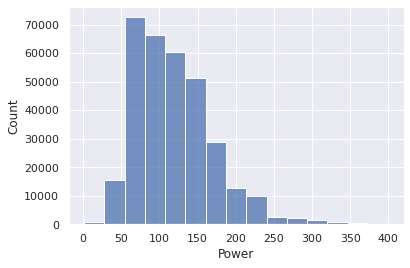

In [223]:
# строим гистограмму для наглядности
sns.histplot(df['Power'], bins=15)

##### Признак ``RegistrationYear``

Посмотрим на количество объявлений с годом регистрации более 2022 и ранее 1900:

In [224]:
print(f"Количество объявлений с годом регистрации более 2022: {len(df.loc[df['RegistrationYear'] > 2022])}")
print(f"Количество объявлений с годом регистрации ранее 1900: {len(df.loc[df['RegistrationYear'] < 1900])}")

Количество объявлений с годом регистрации более 2022: 58
Количество объявлений с годом регистрации ранее 1900: 28


In [225]:
# выведем первые пять строк таблицы на экран
display(df.loc[df['RegistrationYear'] > 2022].head())
display(df.loc[df['RegistrationYear'] < 1900].head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
12946,2016-03-29 18:39:40,49,NaN,5000,NaN,101,golf,5000,12,NaN,volkswagen,NaN,2016-03-29 00:00:00,0,74523,2016-04-06 04:16:14
17271,2016-03-23 16:43:29,700,NaN,9999,NaN,116,other,10000,0,NaN,opel,NaN,2016-03-23 00:00:00,0,21769,2016-04-05 20:16:15
18259,2016-03-16 20:37:54,300,NaN,2200,NaN,58,twingo,5000,12,NaN,renault,NaN,2016-03-16 00:00:00,0,45307,2016-04-07 06:45:32
26382,2016-03-07 20:50:57,150,NaN,3000,NaN,95,a_klasse,5000,0,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,28217,2016-03-08 07:46:23
26560,2016-03-24 17:45:47,800,NaN,2066,NaN,125,zafira,5000,0,gasoline,opel,NaN,2016-03-24 00:00:00,0,45355,2016-03-29 03:16:49


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,131,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
53577,2016-03-20 11:44:28,330,NaN,1000,NaN,60,polo,5000,0,NaN,volkswagen,NaN,2016-03-20 00:00:00,0,45259,2016-04-04 08:17:15
56241,2016-03-30 18:54:27,950,NaN,1400,manual,101,golf,125000,4,petrol,volkswagen,NaN,2016-03-30 00:00:00,0,50389,2016-04-03 09:45:19
71459,2016-03-27 23:46:28,500,NaN,1000,NaN,101,golf,5000,0,NaN,volkswagen,NaN,2016-03-27 00:00:00,0,91628,2016-03-29 13:46:49


Цену с неправильным годом регистрации также будет сложно предсказать, такие объявления могут внести ошибки в модель. Таких объектов мало, и данные по многим другим признакам также пропущены. Удалим эти аномалии.

In [226]:
# отсеиваем года более 2022
df = df.loc[df['RegistrationYear'] <= 2022]
# отсеиваем года ранее 1900
df = df.loc[df['RegistrationYear'] >= 1900]

##### Просмотр обработки результатов

Посмотрим теперь на технические характеристики после обработки аномалий:

In [227]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,325985.000000,325985.000000,325985.000000,325985.000000,325985.000000,325985.0,325985.000000
mean,4623.374517,2003.268147,118.725451,128597.067350,5.853966,0.0,50817.638002
std,4530.487896,7.061790,51.326833,36963.747615,3.665989,0.0,25722.540727
min,1.000000,1910.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30519.000000
50%,2950.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,49661.000000
75%,6650.000000,2008.000000,144.000000,150000.000000,9.000000,0.0,71336.000000
max,20000.000000,2019.000000,400.000000,150000.000000,12.000000,0.0,99998.000000


#### Удаление ненужных данных

Для начала удалим столбцы которые нам не понадобятся для предсказания цены.

In [228]:
# создаем список столбцов для удаления
list_del_column = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode']
# удаляем столбцы
df = df.drop(columns=list_del_column)

Создадим список для категориальных столбцов (в дальнейшем он нам понадобится):

In [229]:
category_columns = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']

#### Обработка пропусков

Как нам стало известно из предварительного анализа датасета мы имеем пропуски в данных. Посмотрим на них:

In [230]:
print(df.isna().sum().sort_values(ascending=False))

NotRepaired          58217
VehicleType          28080
FuelType             23490
Gearbox              14205
Price                    0
RegistrationYear         0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
dtype: int64


Заполним пропуски в столбцах на значение ``'Nan'``:

In [231]:
df[category_columns] = df[category_columns].fillna('Nan')

Проверим прошло ли изменение:

In [232]:
print("Количество пропусков в датасете = ", df.isna().sum().sum())

Количество пропусков в датасете =  0


Как видим изменения прошли успешно.

#### Изменение типа данных

In [233]:
# изменим тип данных категориальных столбцов на "category"
for col in category_columns:
    df[col] = df[col].astype('category')

### Разбивка данных на выборки

Определим целевое значение и признаки. Из задания нам известен целевой признак, это ``Price`` — цена (евро).

In [234]:
X = df.drop(columns='Price') # признаки
y = df['Price'] # целевое значение

Разобьем данные на train и test:

In [235]:
# задаем значение random_state
rand = 13

In [236]:
# разделяемм данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

``Train`` дополнительно разобьем на ``train_valid`` и ``valid``:

In [237]:
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=rand)

Посмотрим на размеры выборок:

In [238]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print('\nX_train_valid:', X_train_valid.shape)
print('y_train_valid:', y_train_valid.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (260788, 10)
y_train: (260788,)
X_test: (65197, 10)
y_test: (65197,)

X_train_valid: (208630, 10)
y_train_valid: (208630,)
X_valid: (52158, 10)
y_valid: (52158,)


### Вывод

Мы открыли и изучили файл с данными, а также сохранили их в отдельной переменной. Провели предобработку данных: удалили ненужные для предсказания столбцы, обработали пропущенные значения, а также произвели разбивку данных на выборки.

## Обучение моделей

В данном разделе напишем функцию для расчета параметров времени и RMSE, затем выполним проверку трех моделей: ``LightGBM``, ``CatBoost`` и ``Ridge``. Для каждой модели найдем наилучшие гиперпараметры и произведем расчет времени обучения на ``train`` выборке.

### Функция для расчета параметров времени и RMSE

Напишем функцию, на вход которой будут подаваться модель и датасеты(выборки) и она будет возвращать время обучения, время предсказания и RMSE.

In [239]:
def calculation_model_parameter(model, X_train, y_train, X_test, y_test):
    '''
    Функция принимает на вход модель и датасеты для обучения модели и расчета предсказаний.
    Возвращает время обучения, время предсказания и RMSE.
    '''
    
    start = time.time() # сохраняем значение времени перед обучением
    model.fit(X_train, y_train) # обучаем модель
    training_time = time.time() - start # рассчитываем время обучения
    
    start = time.time() # # сохраняем значение времени перед обучением
    y_pred = model.predict(X_test) # получаем предсказания
    predict_time = time.time() - start # рассчитываем время предсказания

    return training_time, predict_time, mse(y_test, y_pred)**0.5 # возвращаем время обучения, время предсказания и RMSE

### Проверка моделей

Выполним проверку трех моделей: ``Ridge``,``CatBoost`` и ``LightGBM``.

#### Модель ``Ridge``

Найдем лучшие параметры модели ``Ridge`` на кросс-валидации:

In [240]:
model_Ridge = GridSearchCV(Pipeline([                # инициализируем пайплайн
    ('ohe', OneHotEncoder(handle_unknown='ignore')), # кодируем признаки
    ('scaler', StandardScaler(with_mean=False)),     # масштабируем признаки
    ('model', Ridge(random_state=rand))              # модель "Ridge"
]),
                    param_grid = [{'model__alpha': np.logspace(-2, 2, 20)}],
                    cv = KFold(n_splits=3, shuffle=True, random_state=rand),
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

Произведем расчет времени обучения:

In [241]:
%%time
model_Ridge.fit(X_train_valid, y_train_valid);

CPU times: user 51 s, sys: 24.9 ms, total: 51.1 s
Wall time: 52.5 s


GridSearchCV(cv=KFold(n_splits=3, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('ohe',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(random_state=13))]),
             n_jobs=-1,
             param_grid=[{'model__alpha': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])}],
             scoring='neg_mean_squared_error', verbose=False)

In [242]:
# наилучшие результаты
model_Ridge.best_params_

{'model__alpha': 100.0}

#### Модель ``CatBoost``

In [243]:
# закодируем данные
encoders = {}
for i in category_columns:
    encoders[i] = preprocessing.LabelEncoder()
    df[i] = encoders[i].fit_transform(df[i])

Найдем лучшие параметры модели ``CatBoost`` на кросс-валидации:

In [244]:
model_CatBoost = GridSearchCV(
    CatBoostRegressor(random_seed=rand, loss_function='RMSE', silent=True, cat_features=category_columns),
    {'learning_rate': np.logspace(-3, 0, 5), 'iterations': [40, 60], 'depth': [6, 8, 10]},
    cv = KFold(n_splits=3, shuffle=True, random_state=rand),
    scoring='neg_mean_squared_error',
    verbose=False)

Произведем расчет времени обучения:

In [245]:
%%time
model_CatBoost.fit(X_train_valid, y_train_valid)

CPU times: user 17min 18s, sys: 4.22 s, total: 17min 22s
Wall time: 19min 49s


GridSearchCV(cv=KFold(n_splits=3, random_state=13, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f740759dbb0>,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             scoring='neg_mean_squared_error', verbose=False)

In [246]:
# наилучшие результаты
model_CatBoost.best_params_

{'depth': 10, 'iterations': 60, 'learning_rate': 0.1778279410038923}

#### Модель ``LightGBM``

In [247]:
gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=rand)


params = {
    'learning_rate': [1.0],
    'max_depth': [15],
    'num_leaves': [41],
    'force_col_wise': ['True'],
}

model_LGBM = GridSearchCV(gbm,
                        params,
                        cv = KFold(n_splits=3, shuffle=True, random_state=rand),
                        scoring='neg_mean_squared_error',
                        verbose=True)

Произведем расчет времени обучения:

In [248]:
%%time
model_LGBM.fit(X_train_valid, y_train_valid)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 3min 15s, sys: 872 ms, total: 3min 15s
Wall time: 3min 17s


GridSearchCV(cv=KFold(n_splits=3, random_state=13, shuffle=True),
             estimator=LGBMRegressor(seed=13, verbose=0),
             param_grid={'force_col_wise': ['True'], 'learning_rate': [1.0],
                         'max_depth': [15], 'num_leaves': [41]},
             scoring='neg_mean_squared_error', verbose=True)

In [249]:
# наилучшие результаты
model_LGBM.best_params_

{'force_col_wise': 'True',
 'learning_rate': 1.0,
 'max_depth': 15,
 'num_leaves': 41}

## Анализ моделей

Сведем все данные в один датафрейм и посмотрим результаты на валидационной выборке:

In [250]:
# создадим лист для записи параметров моделей
list_params_model = []

In [251]:
# добавляем параметры модели "Ridge"
list_params_model.append(calculation_model_parameter(model_Ridge.best_estimator_,
                                                     X_train_valid, y_train_valid, X_valid, y_valid))

# добавляем параметры модели "CatBoost"
list_params_model.append(calculation_model_parameter(model_CatBoost.best_estimator_,
                                                     X_train_valid, y_train_valid, X_valid, y_valid))

# добавляем параметры модели "LightGBM"
list_params_model.append(calculation_model_parameter(model_LGBM.best_estimator_,
                                                     X_train_valid, y_train_valid, X_valid, y_valid))

Выведем на экран таблицу результатов:

In [252]:
# создание датафрейма
pd.DataFrame(data=list_params_model,
             index=['Модель "Ridge"', 'Модель "CatBoost"', 'Модель "LightGBM"'],
             columns=['Время обучения', 'Время предсказания', 'RMSE'])

,Время обучения,Время предсказания,RMSE
"Модель ""Ridge""",1.040817,0.117271,2039.330668
"Модель ""CatBoost""",24.699027,0.067964,1716.956645
"Модель ""LightGBM""",7.446241,0.503243,1789.971372


По моему мнению в данном случае наиболее подходящей моделью, с **оптимальным качеством и быстродействием** оказался: ``LightGBM``

## Общий вывод

В процессе проведения исследовательского анализа данных мы открыли и изучили файл, проанализировали признаки. Провели предобработку данных, обработали пропущенные значения и избавились от ненужных для предсказания цены данных.

В разделе "обучение моделей" написали функцию для расчета параметров времени и RMSE, затем выполнили проверку трех моделей: ``Ridge``, ``CatBoost`` и ``LightGBM``. Для каждой модели нашли наилучшие гиперпараметры и произвели расчет времени обучения на ``train`` выборке. Наилучшей моделью c моей точки зрения показала себя ``LightGBM``.

**``P.S.``**
* Для обучения моделей перепробовал огромное количество гиперпараметров с разными значениями, но для ускорения обучения оставил только несколько из них, иначе попросту тонна времени уходила на проверку!!!